# Titanic Data #

## Questions on data ##

   - Was it more likely to survive as male or female passenger?
   - Was ist more likely to survive as first, second or third class passenger?
   - Was ist more likely to survive on the different location of embarkments?
   - Was ist more like to survive as a family member or single person?
   
   

In [102]:
import pandas as pd
import seaborn as sns

filename = 'titanic-data.csv'
titanic_df = pd.read_csv(filename)

## Analysis of data in dataset ##

### Structure of dataset ###

|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked
|-|-|-|-|-|-|-|-|-|-|-|
|Passenger Id|Survival (0 = No; 1 = Yes)|Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)|Name|Sex|Age|Number of Siblings/Spouses Aboard|Number of Parents/Children Aboard|Ticket Number|Passenger Fare|Cabin|Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

** Example data **

In [103]:
titanic_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Problems in the dataset ###

In [104]:
titanic_df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

Not for all passengers the 'Age' is available

Not for all passengers 'Cabin' available

Not for all passengers 'Embarked' is available

### Data Wrangling ###

We removing the columns Name, Ticket, Fare and Cabin as we do not need them to answer our questions.

In [105]:
del titanic_df['Name']
del titanic_df['Ticket']
del titanic_df['Fare']
del titanic_df['Cabin']

### Analysis of dataset ###

#### Overall Survival Probability ####

Survival Probability of all passengers in dataset:

In [106]:
titanic_df.mean()['Survived']

0.38383838383838381

####  Was it more likely to survive as male or female passenger? ####

Survival rate by sex:

In [107]:
titanic_df.groupby('Sex').mean()['Survived']

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

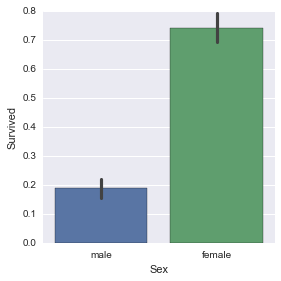

In [108]:
sns.factorplot(x = 'Sex', y = 'Survived', data = titanic_df, kind = 'bar')

** Conclusion **

The Survival rate of the female passengers (74,2%) in the dataset is higher than the overall survival rate (38.4%) and higher than the survival rate of the male passengers (18.9%). This is due the fact that female passengers (and children) are rescued first. (["Women and children first" code of conduct](https://en.wikipedia.org/wiki/Women_and_children_first))

#### Was ist more likely to survive as first, second or third class passenger? ####

Survival rate by passenger class

In [109]:
titanic_df.groupby('Pclass').mean()['Survived']

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

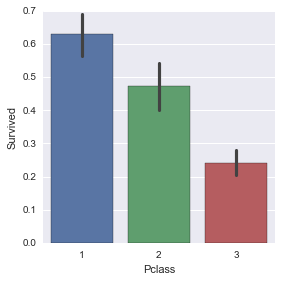

In [110]:
sns.factorplot(x = 'Pclass', y ='Survived', data = titanic_df, kind = 'bar')

** Conclusion **

The Survival probality of first class passengers was the highest (63.0 %). On the other hand the class 2 had a very low probability of surviving the desaster (24.2 %). This is due the fact, that first class passengers where on top of the ship and most probably as well because of the social status. This is interesting question.Accoording to [The layout of the titanic](http://www.dummies.com/education/history/titanic-facts-the-layout-of-the-ship/) the first class cabins were located in Deck C. Second and third class passengers were located in Deck D and E. As the cabins of the second and third class  were on the same decks, and the survival probability were much lower for the third class the 
It shows that 

![Titanic deck layout](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/400px-Titanic_cutaway_diagram.png "Titanic deck layout")



#### Was ist more likely to survive on the different location of embarkments? ####

Survival rate by embarkement location:

In [111]:
titanic_df.groupby('Embarked').mean()['Survived']

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

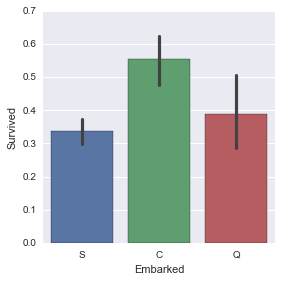

In [112]:
sns.factorplot(x = 'Embarked', y = 'Survived', data = titanic_df, kind = 'bar')

Passengers by embarkment location and class:

In [113]:
titanic_df.groupby(['Embarked','Pclass',]).size() / titanic_df.groupby('Embarked').size()

Embarked  Pclass
C         1         0.505952
          2         0.101190
          3         0.392857
Q         1         0.025974
          2         0.038961
          3         0.935065
S         1         0.197205
          2         0.254658
          3         0.548137
dtype: float64

** Conclusion **

The probabilty of surviving the titanic disaster was highest if someone boarded in Cherbourg.
This is because a lot of passengers who embarked in Cherbourg had first class ticket.

#### Was ist more like to survive as a family member or single person? ####